# TASK #1: PROJECT OVERVIEW AND BUSINESS CASE

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

# TASK #2: IMPORT LIBRARIES/DATASETS AND PERFORM PRELIMINARY DATA PROCESSING

In [ ]:
import pandas as pd
import  numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import  Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from IPython.display import display


In [13]:
# load the data
facialpoints_df = pd.read_csv('KeyFacialPoints.csv')

In [ ]:
facialpoints_df.head()

In [14]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
# Let's take a look at a sample image
facialpoints_df['Image'][1]

In [15]:
# Since values for the image is given as space separated string, we will need to separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [16]:
# Let's obtain the shape of the resized image
facialpoints_df['Image'][1].shape

(96, 96)

In [17]:
# Let's confirm that there are no null values
facialpoints_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

MINI CHALLENGE #1
- Obtain the average, minimum and maximum values for 'right_eye_center_x'

# TASK #3: PERFORM IMAGE VISUALIZATION

In [ ]:
# Plot a random image from the dataset along with facial keypoints.
i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i],cmap='gray')


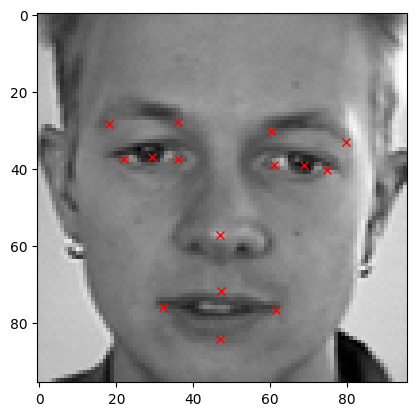

In [25]:
# The (x, y) coordinates for the 15 key features are plotted on top of the image
# Below is a for loop starting from index = 1 to 32 with step of 2
# In the first iteration j would be 1, followed by 3 and so on.
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.
# in the first iteration df[i][j-1] would be df[i][0] refering the value in 1st column(x-coordinate) of the image in 'i' row.

plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,len(facialpoints_df.columns.values), 2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


In [ ]:
import random

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


MINI CHALLENGE #2
- Plot 64 random images from the training data instead of the 16
- HINT: You might need to choose 'random' to select random images

# TASK #4: PERFORM IMAGE AUGMENTATION

In [28]:
# Create a new copy of the dataframe
import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [29]:
# obtain the header of the DataFrame (names of columns)

columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [30]:
# Take a look at the pixel values of a sample image and see if it makes sense!
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [ ]:
# plot the sample image
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray')

In [45]:
# Now Let's flip the image column horizontally
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

In [ ]:
# Now take a look at the flipped image and do a sanity check!
# Notice that the values of pixels are now flipped
facialpoints_df_copy['Image'][0]

In [ ]:
# Notice that the image is flipped now
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

In [38]:
# Since we are flipping the images horizontally, y coordinate values would be the same
# X coordinate values only would need to change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

In [ ]:
# View the Original image
plt.imshow(facialpoints_df['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[0][j-1], facialpoints_df.loc[0][j], 'rx')

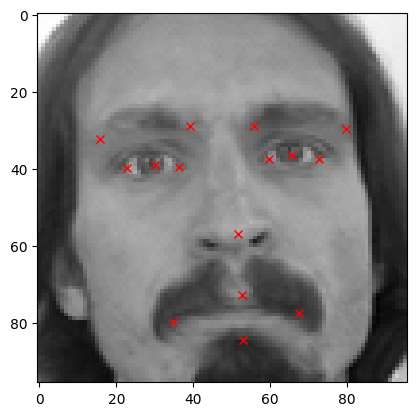

In [47]:
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [48]:
# Concatenate the original dataframe with the augmented dataframe
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [49]:
facialpoints_df_augmented.shape

(4280, 31)

In [51]:
# Let's try to perform another image augmentation by randomly increasing images brightness
# We multiply pixel values by random values between 1 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x: np.clip(random.uniform(1, 2) * x, 0.0, 2.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

In [ ]:
# Let's view image with increased brightness

plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

MINI CHALLENGE #3:
- Augment images by flipping them vertically
(Hint: Flip along x-axis and note that if we are flipping along x-axis, x co-ordinates won't change)


# TASK #5: PERFORM NORMALIZATION AND TRAINING DATA PREPARATION

In [55]:
# Obtain the value of 'Images' and normalize it
# Note that 'Images' are in the 31st column but since indexing start from 0, we refer 31st column by 30
img = facialpoints_df_augmented[:, 30] / 255.

# Create an empty array of shape (10700, 96, 96, 1) to train the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the normalized images list and add image values to the empty array
# Note that we need to expand it's dimension from (96,96) to (96,96,1)
for i in range(len(img)):
  X[i] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape


(6420, 96, 96, 1)

In [56]:
# Obtain the values of key face points coordinates, which are to used as target.
y = facialpoints_df_augmented[:, :30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [58]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

MINI CHALLENGE #4:
- Try a different value for 'test_size' and check the size of the training and testing datasets
- Randomly visualize 64 images from the original and augmented data. Does the data makes sense?

# TASK #6: UNDERSTAND THE THEORY AND INTUITION BEHIND DEEP NEURAL NETWORKS

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

# TASK #7: BUILD DEEP RESIDUAL NEURAL NETWORK MODEL

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [59]:
def res_block(X, filter, stage):

  # CONVOLUTIONAL BLOCK
  X_copy = X
  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Add data from main and short paths
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  # IDENTITY BLOCK 1
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  # IDENTITY BLOCK 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

MINI CHALLENGE #5:
- Experiment with changing the network architecture by removing 2 MaxPooling layers from the Res Block. What did you notice when you print out the network summary?
- Try to add 'X = res_block(X, filter= [256,256,1024], stage= 4)' Block after stage #3 block and make sure the change is reflected on the network summary

# TASK #8: COMPILE AND TRAIN DEEP LEARNING MODEL

In [61]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [63]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 70, validation_split = 0.05, callbacks=[checkpointer])

In [77]:
# Save trained model
model_json = model.to_json()
with open('KeyPointDetector.json', 'w') as json_file:
        json_file.write(model_json)

MINI CHALLENGE #6 (TAKE HOME):
- Experiment with changing the batch size and validation split value and retrain the model
- Try to improve model performance. Comment on your answer


# TASK #9: ASSESS TRAINED MODEL PERFORMANCE

In [78]:
# instead of training from scratch, you can load trained model weights
with open('KeyPointDetector.json', 'r') as json_file:
    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [79]:
# Evaluate trained model
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

21/21 [==============================] - 1s 9ms/step - loss: 391.1884 - accuracy: 0.6885
Accuracy : 0.6884735226631165


In [80]:
# Make prediction using the testing dataset
df_predict = model.predict(X_test)

21/21 [==============================] - 1s 7ms/step


In [81]:
# Print the rmse loss values

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 19.778484422344444


In [75]:
# Convert the predicted values into a dataframe

df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,48.435120,26.924809,21.262873,27.016726,43.730175,27.352955,53.497501,27.246992,26.128712,26.625462,...,34.810520,41.220284,45.738522,55.855927,23.287872,55.507664,35.091984,52.294338,34.644485,60.591755
1,47.392262,26.362747,20.765745,26.439545,42.685349,26.805004,52.190666,26.480087,25.526987,26.045927,...,33.916840,40.527905,44.744827,54.570827,22.714621,54.208084,34.287003,51.227211,33.786251,59.217392
2,46.554424,25.786385,20.081161,25.815956,41.954002,26.278664,51.442070,25.904095,24.943495,25.445227,...,33.283825,39.418171,43.928001,53.246346,22.115526,53.008301,33.600163,49.927876,33.114628,57.980907
3,48.008301,26.658005,20.805567,26.626770,43.270710,27.033703,52.870461,26.723692,25.720654,26.200060,...,34.261158,40.729305,45.229355,55.041969,22.858610,54.683556,34.662041,51.579689,34.121326,59.730061
4,48.059666,26.572159,20.580580,26.510096,43.295139,26.922163,52.949005,26.622778,25.509575,26.113543,...,34.164158,40.519863,45.177998,54.783089,22.650743,54.446198,34.574234,51.306557,33.996876,59.527306


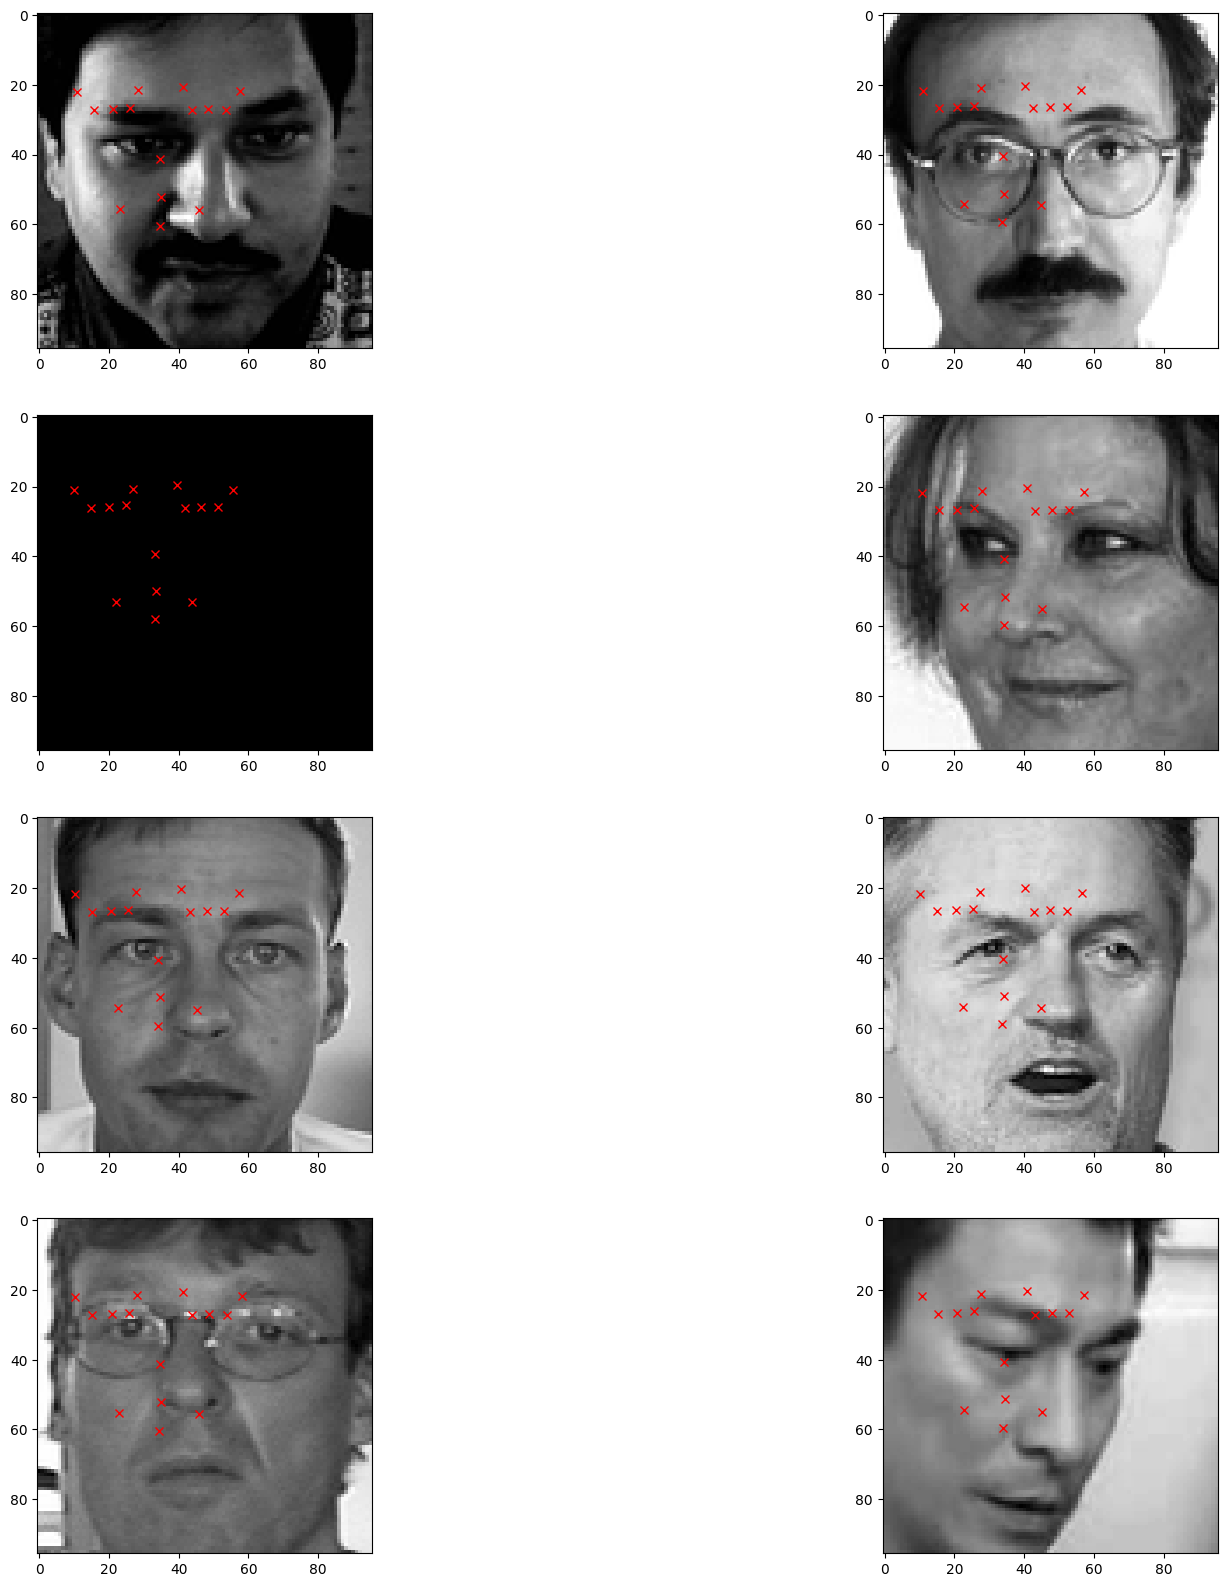

In [76]:
# Plot the test images and their predicted keypoints

fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

# CONGRATULATIONS ON FINISHING THE PROJECT

MINI CHALLENGE SOLUTIONS

MINI CHALLENGE #1

In [ ]:
facialpoints_df.describe()

MINI CHALLENGE #2

In [ ]:
import random

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    img = np.random.randint(1, len(facialpoints_df))
    ax = fig.add_subplot(8, 8, i + 1)
    image = plt.imshow(facialpoints_df['Image'][img], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[img][j-1], facialpoints_df.loc[img][j], 'rx')


MINI CHALLENGE #3

In [ ]:
facialpoints_df_copy = copy.copy(facialpoints_df)

# Flip the image column vertically (note that axis = 0)
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

facialpoints_df['Image'][0]

facialpoints_df_copy['Image'][0]

# Since we are flipping the images vertically, x coordinate values would be the same
# y coordinate values only would need to change, all we have to do is to subtract our initial y-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 1:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')facialpoints_df_copy = copy.copy(facialpoints_df)


MINI CHALLENGE #4

In [ ]:
X_train.shape
X_test.shape

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)
    image = plt.imshow(X_train[i].reshape(96,96), cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(y_train[i][j-1], y_train[i][j], 'rx')


MINI CHALLENGE #5

- Simply comment out the 2 maxpooling layers, you will notice an increase in the number of trainable parameters.
- Simply add 'X = res_block(X, filter= [256,256,1024], stage= 4)' Block after stage #3 block

MINI CHALLENGE #6 (TAKE HOME EXERCISE)